# MLP 모델 성능 비교: Softmax vs No-Softmax

이 노트북에서는 Softmax가 있는 모델과 없는 모델의 성능을 비교합니다.

## 1. Import 및 데이터 로딩

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from data import trainloader, testloader, classes
from nonsoftmaxmlp import MLP_NoSoftmax
from softmaxmlp import MLP_WithSoftmax
import matplotlib.pyplot as plt

print("데이터 로딩 완료!")

데이터 로딩 완료!


## 2. 학습 함수

In [2]:
def train_and_evaluate(model, model_name, epochs=5, lr=0.001):
    """
    모델 학습 및 평가
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    use_softmax_head = isinstance(model, MLP_WithSoftmax)
    criterion = nn.NLLLoss() if use_softmax_head else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        correct, total = 0, 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if use_softmax_head:
                probs = outputs.clamp_min(1e-12)
                loss = criterion(torch.log(probs), labels)
                preds = probs.argmax(dim=1)
            else:
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
            
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
        train_acc = 100.0 * correct / total
        train_accs.append(train_acc)
        
        # Evaluation
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        test_acc = 100.0 * correct / total
        test_accs.append(test_acc)
        
        print(f"{model_name} - Epoch [{epoch+1}/{epochs}] Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")
    
    return train_accs, test_accs

## 3. 두 모델 학습 및 비교

In [3]:
# 모델 학습
print("=" * 60)
print("MLP (No Softmax) 학습 시작")
print("=" * 60)
model_no_softmax = MLP_NoSoftmax()
train_no, test_no = train_and_evaluate(model_no_softmax, "No Softmax", epochs=10)

print("\n" + "=" * 60)
print("MLP (With Softmax) 학습 시작")
print("=" * 60)
model_with_softmax = MLP_WithSoftmax()
train_with, test_with = train_and_evaluate(model_with_softmax, "With Softmax", epochs=10)

MLP (No Softmax) 학습 시작
No Softmax - Epoch [1/10] Train: 41.02% | Test: 46.73%
No Softmax - Epoch [2/10] Train: 49.21% | Test: 49.79%
No Softmax - Epoch [3/10] Train: 53.57% | Test: 52.82%
No Softmax - Epoch [4/10] Train: 57.10% | Test: 51.37%
No Softmax - Epoch [5/10] Train: 59.84% | Test: 53.49%
No Softmax - Epoch [6/10] Train: 62.75% | Test: 53.96%
No Softmax - Epoch [7/10] Train: 65.31% | Test: 54.61%
No Softmax - Epoch [8/10] Train: 68.20% | Test: 54.29%
No Softmax - Epoch [9/10] Train: 70.69% | Test: 54.31%
No Softmax - Epoch [10/10] Train: 73.32% | Test: 54.76%

MLP (With Softmax) 학습 시작
With Softmax - Epoch [1/10] Train: 41.27% | Test: 47.04%
With Softmax - Epoch [2/10] Train: 49.60% | Test: 49.40%
With Softmax - Epoch [3/10] Train: 54.16% | Test: 50.77%
With Softmax - Epoch [4/10] Train: 57.53% | Test: 53.18%
With Softmax - Epoch [5/10] Train: 60.36% | Test: 54.00%
With Softmax - Epoch [6/10] Train: 63.41% | Test: 54.47%
With Softmax - Epoch [7/10] Train: 65.99% | Test: 55.12%
W

## 4. 결과 시각화

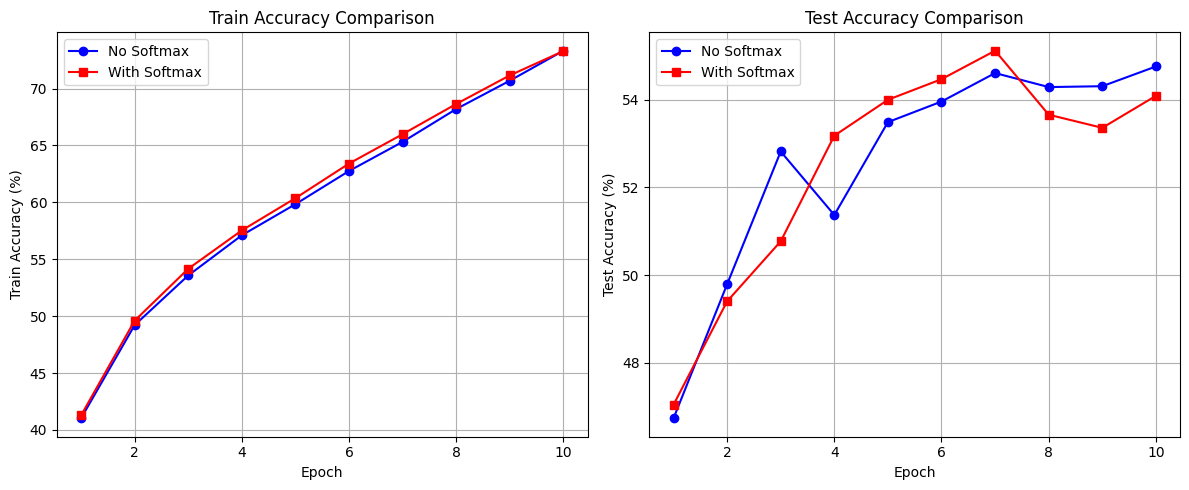


최종 성능 비교
No Softmax  - Train: 73.32% | Test: 54.76%
With Softmax - Train: 73.29% | Test: 54.09%


In [4]:
# 성능 비교 그래프
epochs = range(1, len(train_no) + 1)

plt.figure(figsize=(12, 5))

# Train Accuracy 비교
plt.subplot(1, 2, 1)
plt.plot(epochs, train_no, 'b-o', label='No Softmax')
plt.plot(epochs, train_with, 'r-s', label='With Softmax')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.title('Train Accuracy Comparison')
plt.legend()
plt.grid(True)

# Test Accuracy 비교
plt.subplot(1, 2, 2)
plt.plot(epochs, test_no, 'b-o', label='No Softmax')
plt.plot(epochs, test_with, 'r-s', label='With Softmax')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("최종 성능 비교")
print("=" * 60)
print(f"No Softmax  - Train: {train_no[-1]:.2f}% | Test: {test_no[-1]:.2f}%")
print(f"With Softmax - Train: {train_with[-1]:.2f}% | Test: {test_with[-1]:.2f}%")

## 결론

- 일반적으로 두 모델의 성능은 거의 비슷합니다.
- CrossEntropyLoss를 사용하는 경우(No Softmax)가 더 수치적으로 안정적입니다.
- Softmax + NLLLoss 조합도 잘 작동하지만, log-softmax를 직접 계산하므로 주의가 필요합니다.